In [168]:
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, random_split
import numpy as np
import os
import json
import csv
import time
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import math
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

In [169]:
WINDOW_SIZE = 1440
LEARNING_RATE = 1e-5
EPOCHS = 10
TAU = 3 #threshold value for the preceding SR score values in the paper
q = 3
k = 5 # number of extended values (to bring the last value in the middle)
m = 5
z= 21 # as in the paper~
threshold = 0.5

In [157]:
def spectral_residual(values):
    """
    This method transform a time series into spectral residual series
    :param values: list.
        a list of float values.
    :return: mag: list.
        a list of float values as the spectral residual values
    """
    EPS = 1e-8
    trans = np.fft.fft(values)
    mag = np.sqrt(trans.real ** 2 + trans.imag ** 2)

    maglog = [np.log(item) if abs(item) > EPS else 0 for item in mag]

    spectral = np.exp(maglog - average_filter(maglog, n=q))

    trans.real = [ireal * ispectral / imag if abs(imag) > EPS else 0
                  for ireal, ispectral, imag in zip(trans.real, spectral, mag)]
    trans.imag = [iimag * ispectral / imag if abs(imag) > EPS else 0
                  for iimag, ispectral, imag in zip(trans.imag, spectral, mag)]

    wave_r = np.fft.ifft(trans)
    mag = np.sqrt(wave_r.real ** 2 + wave_r.imag ** 2)

    return mag

def average_filter(values, n=q):
    """
    Calculate the sliding window average for the give time series.
    Mathematically, res[i] = sum_{j=i-t+1}^{i} values[j] / t, where t = min(n, i+1)
    :param values: list.
        a list of float numbers
    :param n: int, default 3.
        window size.
    :return res: list.
        a list of value after the average_filter process.
    """

    if n >= len(values):
        n = len(values)

    res = np.cumsum(values, dtype=float)
    res[n:] = res[n:] - res[:-n]
    res[n:] = res[n:] / n

    for i in range(1, n):
        res[i] /= (i + 1)

    return res

def predict_next(values):
    """
    Predicts the next value by sum up the slope of the last value with previous values.
    Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
    where g(x_i,x_j) = (x_i - x_j) / (i - j)
    :param values: list.
        a list of float numbers.
    :return : float.
        the predicted next value.
    """

    if len(values) <= 1:
        raise ValueError(f'data should contain at least 2 numbers')

    v_last = values[-1]
    n = len(values)

    slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

    return values[1] + sum(slopes)

def extend_series(values, extend_num=k, look_ahead=m):
    """
    extend the array data by the predicted next value
    :param values: list.
        a list of float numbers.
    :param extend_num: int, default 5.
        number of values added to the back of data.
    :param look_ahead: int, default 5.
        number of previous values used in prediction.
    :return: list.
        The result array.
    """

    if look_ahead < 1:
        raise ValueError('look_ahead must be at least 1')

    extension = [predict_next(values[-look_ahead - 1:-1])] * extend_num
    return np.concatenate((values, extension), axis=0)

def normalize(a):
    amin = np.min(a)
    amax = np.max(a)
    a = (a - amin) / (amax - amin + 1e-5)
    return a

def cuda_if_available(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

def calc(pred, true):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for pre, gt in zip(pred, true):
        if gt == 1:
            if pre == 1:
                TP += 1
            else:
                FN += 1
        if gt == 0:
            if pre == 1:
                FP += 1
            else:
                TN += 1
    #print('TP=%d FP=%d TN=%d FN=%d' % (TP, FP, TN, FN))
    return TP, FP, TN, FN

class Anomaly(nn.Module):
    def __init__(self, window=WINDOW_SIZE):
        self.window = window
        super(Anomaly, self).__init__()
        self.layer1 = nn.Conv1d(window, window, kernel_size=1, stride=1, padding=0)
        self.layer2 = nn.Conv1d(window, 2 * window, kernel_size=1, stride=1, padding=0)
        self.fc1 = nn.Linear(2 * window, 4 * window)
        self.fc2 = nn.Linear(4 * window, window)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(x.size(0), self.window, 1)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

def reconstruct_label(timestamp, label):
    timestamp = np.asarray(timestamp, np.int64)
    index = np.argsort(timestamp)

    timestamp_sorted = np.asarray(timestamp[index])
    interval = np.min(np.diff(timestamp_sorted))

    label = np.asarray(label, np.int64)
    label = np.asarray(label[index])

    idx = (timestamp_sorted - timestamp_sorted[0]) // interval

    new_label = np.zeros(shape=((timestamp_sorted[-1] - timestamp_sorted[0]) // interval + 1,), dtype=np.int64)
    new_label[idx] = label

    return new_label

def get_range_proba(predict, label, delay=7):
    predict = np.array(predict)
    label = np.array(label)

    splits = np.where(label[1:] != label[:-1])[0] + 1
    is_anomaly = label[0] == 1
    new_predict = np.array(predict)
    pos = 0

    for sp in splits:
        if is_anomaly:
            if 1 in predict[pos:min(pos + delay + 1, sp)]:
                new_predict[pos: sp] = 1
            else:
                new_predict[pos: sp] = 0
        is_anomaly = not is_anomaly
        pos = sp
    sp = len(label)

    if is_anomaly:
        if 1 in predict[pos: min(pos + delay + 1, sp)]:
            new_predict[pos: sp] = 1
        else:
            new_predict[pos: sp] = 0

    return new_predict

def reconstruct_series(timestamp, label, predict, delay=7):
    label = reconstruct_label(timestamp, label)
    predict = reconstruct_label(timestamp, predict)
    predict = get_range_proba(predict, label, delay)
    return label.tolist(), predict.tolist()

In [158]:
def highlight(indices,ax, thickness=0.5):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-thickness, indices[i]+thickness, facecolor='red', edgecolor='none', alpha=.9)
        i+=1

def plots(values, is_anomaly, interval=[0,100], fig_size=(40,4)):
    df = pd.DataFrame()
    start_index= (len(values) * interval[0]) // 100
    end_index = (len(values) * interval[1]) // 100
    df['value'] = values[start_index:end_index]
    df['is_anomaly'] = is_anomaly[start_index:end_index]
    df = df.reset_index()
    
    ax1 = df.plot(kind='line', x='index', y='value', color='b', figsize=fig_size) 
    highlight(df[df['is_anomaly']==1].index, ax1, 0.5)

In [159]:
class gen_set(Dataset):
    def __init__(self, width, data, label_anomalies=True):
        self.genlen = 0
        self.len = self.genlen
        self.width = width
        self.kpinegraw = data
        self.negrawlen = len(self.kpinegraw)
        print('length :', len(self.kpinegraw))
        self.len += self.negrawlen
        self.kpineglen = 0
        self.control = 0.
        self.label_anomaly = label_anomalies

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        idx = index % self.negrawlen
        datas = self.kpinegraw[idx]
        datas = np.array(datas)
        data = datas[0, :].astype(np.float64)
        lbs = datas[1, :].astype(np.float64)
        wave = spectral_residual(data)
        if self.label_anomaly:
            waveavg = average_filter(wave, n=z)
            for i in range(self.width):
                if wave[i] < 0.001 and waveavg[i] < 0.001:
                    lbs[i] = 0
                    continue
                ratio = wave[i] / waveavg[i]
                if ratio < 1.0 and lbs[i] == 1:
                    lbs[i] = 0
                if ratio > 5.0:
                    lbs[i] = 1
            srscore = abs(wave - waveavg) / (waveavg + 0.001)
            lbs[srscore > TAU] = 1
        resdata = torch.from_numpy(wave)
        reslb = torch.from_numpy(lbs)
        return resdata, reslb

In [160]:
kpis = {}
DATA_PATH=os.getcwd()+'/../sr-cnn/train.csv'
anomalies = 0
with open(DATA_PATH) as f:
    input = csv.reader(f, delimiter=',')
    cnt = 0
    for row in input:
        if cnt == 0:
            cnt += 1
            continue
        kpi = kpis.get(str(row[3]), [[],[],[]])
        kpi[0].append(int(row[0])) #timestamp
        kpi[1].append(float(row[1])) #value
        kpi[2].append(int(row[2])) #label
        kpis[str(row[3])] = kpi
        cnt += 1
        if int(row[2]) == 1:
            anomalies += 1
    f.close()

In [161]:
class gen():
    def __init__(self, win_siz, step, nums):
        self.control = 0
        self.win_siz = win_siz
        self.step = step
        self.number = nums

    def generate_train_data(self, value, labels, back=q, insert_anomalies=True):
        number_anomalies_added = 0
        total_length = 0

        length = len(value)
        tmp = []
        for pt in range(self.win_siz, length - back, self.step):
            head = max(0, pt - self.win_siz)
            tail = min(length - back, pt)
            data = np.array(value[head:tail])
            data = data.astype(np.float64)
            data = normalize(data)
            lbs = np.array(labels[head:tail])
            if insert_anomalies:
                num = np.random.randint(1, self.number)
                ids = np.random.choice(self.win_siz, num, replace=False)
                if (self.win_siz - 6) not in ids:
                    self.control += np.random.random()
                else:
                    self.control = 0
                if self.control > 100:
                    ids[0] = self.win_siz - 6
                    self.control = 0
                mean = np.mean(data)
                dataavg = average_filter(data)
                var = np.var(data)
                for id in ids:
                    rndm = np.random.randn() * 3
                    while abs(rndm) < 0.2:
                        rndm = np.random.randn() * 3
                    data[id] += (dataavg[id] + mean) * (rndm) * min((1 + var), 10)
                    lbs[id] = 1
                    number_anomalies_added += 1
            total_length += len(data)
            tmp.append([data.tolist(), lbs.tolist()])
        print('number of anomalies added:', number_anomalies_added, ' total length of data:', total_length)
        return tmp

In [162]:
train_kpis = {}
validation_kpis = {}
rate = 1
for kpi_id in kpis:
    kpi = kpis[kpi_id]
    train_length = math.ceil(len(kpi[0]) * rate)
    train_kpis[kpi_id] = [kpi[0][0:train_length], kpi[1][0:train_length], kpi[2][0:train_length]]
    validation_kpis[kpi_id] = [kpi[0][train_length:], kpi[1][train_length:], kpi[2][train_length:]]

In [163]:
MAX_NUMBER_OF_ANOMALOUS_POINTS_TO_ADD = 10

training_data = {}
validation_data = []
generator = gen(WINDOW_SIZE, WINDOW_SIZE, MAX_NUMBER_OF_ANOMALOUS_POINTS_TO_ADD)
for kpi_id in kpis:
    train_kpi = train_kpis[kpi_id]
    in_timestamp = train_kpi[0]
    in_value = train_kpi[1]
    in_label = train_kpi[2]
    train_data = generator.generate_train_data(in_value, in_label, insert_anomalies=False)
    training_data[kpi_id] = train_data
    
    #valid_kpi = validation_kpis[kpi_id]
    #vld_data = generator.generate_train_data(valid_kpi[1], valid_kpi[2], insert_anomalies=False)
    #validation_data += vld_data

number of anomalies added: 0  total length of data: 107280
number of anomalies added: 0  total length of data: 8640
number of anomalies added: 0  total length of data: 10800
number of anomalies added: 0  total length of data: 8640
number of anomalies added: 0  total length of data: 8640
number of anomalies added: 0  total length of data: 8640
number of anomalies added: 0  total length of data: 8640
number of anomalies added: 0  total length of data: 8640
number of anomalies added: 0  total length of data: 128880
number of anomalies added: 0  total length of data: 128160
number of anomalies added: 0  total length of data: 128880
number of anomalies added: 0  total length of data: 128160
number of anomalies added: 0  total length of data: 128160
number of anomalies added: 0  total length of data: 128160
number of anomalies added: 0  total length of data: 128880
number of anomalies added: 0  total length of data: 146160
number of anomalies added: 0  total length of data: 146160
number of 

In [164]:
gen_data_train = {}
for kpi_id in training_data:
    kpi = training_data[kpi_id]
    gen_data_train[kpi_id] = gen_set(WINDOW_SIZE, kpi, label_anomalies=False)

length : 149
length : 12
length : 15
length : 12
length : 12
length : 12
length : 12
length : 12
length : 179
length : 178
length : 179
length : 178
length : 178
length : 178
length : 179
length : 203
length : 203
length : 203
length : 203
length : 201
length : 150
length : 150
length : 147
length : 202
length : 203
length : 203
length : 203
length : 203
length : 203


In [165]:
training_final = []
validation_final = []
for kpi_id in gen_data_train:
    kpi = gen_data_train[kpi_id]
    n_train = math.ceil(len(kpi) *0.5)
    n_validate = len(kpi) - n_train
    train_data, validation_data = torch.utils.data.random_split(kpi,[n_train,n_validate])
    training_final += train_data
    validation_final += validation_data

In [166]:
def adjust_lr(optimizer, epoch):
    cur_lr = LEARNING_RATE * (0.5 ** ((epoch + 10) // 10))
    print('Learning rate changed to: ', cur_lr)
    for param in optimizer.param_groups:
        param['lr'] = cur_lr

def Var(x):
    return Variable(cuda_if_available(x))

def loss_function(x, lb, win_size=WINDOW_SIZE):
    l2_reg = 0.
    l2_weight = 0.5
    for W in net.parameters():
        l2_reg = l2_reg + W.norm(2)
    kpiweight = torch.ones(lb.shape)
    kpiweight[lb == 1] = win_size // 100
    kpiweight = cuda_if_available(kpiweight)
    BCE = F.binary_cross_entropy(x, lb, weight=kpiweight, reduction='mean')
    #print(l2_reg.item(), l2_weight, BCE.item())
    #print(x.shape[0])
    return l2_reg * l2_weight / x.shape[0] + BCE

def train(epoch, net, train_loader, valid_loader, optimizer):
    
    net.train()
    train_loss = 0.
    totTP, totFP, totTN, totFN = 0, 0, 0, 0
    for batch_idx, (inputs, lb) in enumerate(tqdm(train_loader, desc="Iteration")):
        optimizer.zero_grad()
        
        
        # forward propagate
        inputs = inputs.float()
        lb = lb.float()        
        valueseq = Var(inputs)
        lb = Var(lb)
        output = net(valueseq)
        
        
        loss1 = loss_function(output, lb)
        loss1.backward()
        train_loss += loss1.item()
        optimizer.step()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
        
        if batch_idx % train_loader.batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader),
                       loss1.item()))
            
    
    net.eval()
    valid_loss = 0.0
    for batch_idx, (inputs, lb) in enumerate(tqdm(valid_loader, desc="Iteration")):
        inputs = inputs.float()
        lb = lb.float()        
        valueseq = Var(inputs)
        lb = Var(lb)
        output = net(valueseq)
        loss1 = loss_function(output, lb)
        valid_loss += loss1.item()
        
        aa = output.detach().cpu().numpy().reshape(-1)
        res = np.zeros(aa.shape, np.int64)
        res[aa > threshold] = 1
        bb = lb.detach().cpu().numpy().reshape(-1)
        res = get_range_proba(res, bb, delay=7)
        TP, FP, TN, FN = calc(res, bb)
        totTP += TP
        totFP += FP
        totTN += TN
        totFN += FN
        
    #accuracy = (totTP + totTN) * 100. / (totTP+totFP+totTN+totFN)
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')
    accuracy = (totTP + totTN) * 100. / (totTP+totFP+totTN+totFN)
    precision = totTP * 1. / (totTP + totFP) if totTP + totFP != 0 else 0
    recall = totTP * 1. / (totTP + totFN) if totTP + totFN != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

In [167]:
model = Anomaly(WINDOW_SIZE)

if torch.cuda.is_available():
    net = model.cuda()
    gpu_num = torch.cuda.device_count()
    net = torch.nn.DataParallel(net, list(range(gpu_num)))
    print(net)
else:
    net = model.cpu()


bp_parameters = filter(lambda p: p.requires_grad, net.parameters()) # back propagation parameters
optimizer = optim.SGD(bp_parameters, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0)


#n_train = math.ceil(len(gen_data) *0.5)
#n_validate = len(gen_data) - n_train
#train_data, validation_data = torch.utils.data.random_split(gen_data,[n_train,n_validate])


train_loader = torch.utils.data.DataLoader(dataset=training_final, shuffle=True, 
                                                 batch_size=9, pin_memory=True)

valid_loader = torch.utils.data.DataLoader(dataset=validation_final, shuffle=True, 
                                                 batch_size=64, pin_memory=True)

for epoch in range(1, EPOCHS + 1):
    print('epoch :', epoch)
    train(epoch, net, train_loader, valid_loader, optimizer)
    adjust_lr(optimizer, epoch)

epoch : 1


Train Epoch: 1 [0/233 (0%)]	Loss: 5.518833
Train Epoch: 1 [9/233 (4%)]	Loss: 5.870259
Train Epoch: 1 [18/233 (8%)]	Loss: 5.282537
Train Epoch: 1 [27/233 (12%)]	Loss: 5.151562
Train Epoch: 1 [36/233 (15%)]	Loss: 5.030501
Train Epoch: 1 [45/233 (19%)]	Loss: 4.949534
Train Epoch: 1 [54/233 (23%)]	Loss: 5.336048
Train Epoch: 1 [63/233 (27%)]	Loss: 4.972167
Train Epoch: 1 [72/233 (31%)]	Loss: 5.043755
Train Epoch: 1 [81/233 (35%)]	Loss: 4.466420
Train Epoch: 1 [90/233 (39%)]	Loss: 4.858471
Train Epoch: 1 [99/233 (42%)]	Loss: 4.709808
Train Epoch: 1 [108/233 (46%)]	Loss: 4.137633
Train Epoch: 1 [117/233 (50%)]	Loss: 4.608721
Train Epoch: 1 [126/233 (54%)]	Loss: 3.908751
Train Epoch: 1 [135/233 (58%)]	Loss: 3.926618
Train Epoch: 1 [144/233 (62%)]	Loss: 3.705049
Train Epoch: 1 [153/233 (66%)]	Loss: 3.685721
Train Epoch: 1 [162/233 (70%)]	Loss: 3.480551
Train Epoch: 1 [171/233 (73%)]	Loss: 3.355182
Train Epoch: 1 [180/233 (77%)]	Loss: 3.244883
Train Epoch: 1 [189/233 (81%)]	Loss: 3.131428
Train


Epoch 2 		 Training Loss: 4.220601757196909 		 Validation Loss: 1.0727318579500371
Accuracy: 32.353205231280484
Precision: 0.03348786813882244
Recall: 0.954130696098787
F1-score: 0.06470474350150392
Learning rate changed to:  0.05
epoch : 2


Train Epoch: 2 [0/233 (0%)]	Loss: 2.590951
Train Epoch: 2 [9/233 (4%)]	Loss: 2.553619
Train Epoch: 2 [18/233 (8%)]	Loss: 2.443672
Train Epoch: 2 [27/233 (12%)]	Loss: 2.371562
Train Epoch: 2 [36/233 (15%)]	Loss: 2.547051
Train Epoch: 2 [45/233 (19%)]	Loss: 2.266432
Train Epoch: 2 [54/233 (23%)]	Loss: 2.494053
Train Epoch: 2 [63/233 (27%)]	Loss: 2.178802
Train Epoch: 2 [72/233 (31%)]	Loss: 2.092106
Train Epoch: 2 [81/233 (35%)]	Loss: 2.042001
Train Epoch: 2 [90/233 (39%)]	Loss: 2.006993
Train Epoch: 2 [99/233 (42%)]	Loss: 1.969601
Train Epoch: 2 [108/233 (46%)]	Loss: 1.923425
Train Epoch: 2 [117/233 (50%)]	Loss: 1.900231
Train Epoch: 2 [126/233 (54%)]	Loss: 1.836232
Train Epoch: 2 [135/233 (58%)]	Loss: 1.848036
Train Epoch: 2 [144/233 (62%)]	Loss: 1.829398
Train Epoch: 2 [153/233 (66%)]	Loss: 1.855820
Train Epoch: 2 [162/233 (70%)]	Loss: 1.726089
Train Epoch: 2 [171/233 (73%)]	Loss: 1.749975
Train Epoch: 2 [180/233 (77%)]	Loss: 1.668443
Train Epoch: 2 [189/233 (81%)]	Loss: 2.368032
Train


Epoch 3 		 Training Loss: 2.081876603830526 		 Validation Loss: 0.9138798966552272
Accuracy: 26.62231334083722
Precision: 0.031018466832887656
Recall: 0.956398207846137
F1-score: 0.060088120546985896
Learning rate changed to:  0.05
epoch : 3


Train Epoch: 3 [0/233 (0%)]	Loss: 2.320526
Train Epoch: 3 [9/233 (4%)]	Loss: 1.503684
Train Epoch: 3 [18/233 (8%)]	Loss: 1.644526
Train Epoch: 3 [27/233 (12%)]	Loss: 1.402719
Train Epoch: 3 [36/233 (15%)]	Loss: 1.387228
Train Epoch: 3 [45/233 (19%)]	Loss: 1.344457
Train Epoch: 3 [54/233 (23%)]	Loss: 1.355686
Train Epoch: 3 [63/233 (27%)]	Loss: 1.287598
Train Epoch: 3 [72/233 (31%)]	Loss: 1.287160
Train Epoch: 3 [81/233 (35%)]	Loss: 1.243380
Train Epoch: 3 [90/233 (39%)]	Loss: 1.200508
Train Epoch: 3 [99/233 (42%)]	Loss: 1.201621
Train Epoch: 3 [108/233 (46%)]	Loss: 1.845470
Train Epoch: 3 [117/233 (50%)]	Loss: 1.175257
Train Epoch: 3 [126/233 (54%)]	Loss: 1.441228
Train Epoch: 3 [135/233 (58%)]	Loss: 1.313864
Train Epoch: 3 [144/233 (62%)]	Loss: 2.087204
Train Epoch: 3 [153/233 (66%)]	Loss: 1.106765
Train Epoch: 3 [162/233 (70%)]	Loss: 1.130163
Train Epoch: 3 [171/233 (73%)]	Loss: 1.085950
Train Epoch: 3 [180/233 (77%)]	Loss: 1.084793
Train Epoch: 3 [189/233 (81%)]	Loss: 1.062233
Train


Epoch 4 		 Training Loss: 1.317733891020517 		 Validation Loss: 0.8393513343550942
Accuracy: 55.33258294473924
Precision: 0.04735344827586207
Recall: 0.9003933996284559
F1-score: 0.08997493871177334
Learning rate changed to:  0.05
epoch : 4


Train Epoch: 4 [0/233 (0%)]	Loss: 0.986364
Train Epoch: 4 [9/233 (4%)]	Loss: 0.981780
Train Epoch: 4 [18/233 (8%)]	Loss: 0.966888
Train Epoch: 4 [27/233 (12%)]	Loss: 1.021001
Train Epoch: 4 [36/233 (15%)]	Loss: 0.930476
Train Epoch: 4 [45/233 (19%)]	Loss: 1.107756
Train Epoch: 4 [54/233 (23%)]	Loss: 0.885090
Train Epoch: 4 [63/233 (27%)]	Loss: 0.905674
Train Epoch: 4 [72/233 (31%)]	Loss: 0.858419
Train Epoch: 4 [81/233 (35%)]	Loss: 0.855047
Train Epoch: 4 [90/233 (39%)]	Loss: 0.834518
Train Epoch: 4 [99/233 (42%)]	Loss: 0.816491
Train Epoch: 4 [108/233 (46%)]	Loss: 0.806314
Train Epoch: 4 [117/233 (50%)]	Loss: 0.845096
Train Epoch: 4 [126/233 (54%)]	Loss: 1.236246
Train Epoch: 4 [135/233 (58%)]	Loss: 1.222304
Train Epoch: 4 [144/233 (62%)]	Loss: 0.749244
Train Epoch: 4 [153/233 (66%)]	Loss: 0.746255
Train Epoch: 4 [162/233 (70%)]	Loss: 0.772041
Train Epoch: 4 [171/233 (73%)]	Loss: 1.165132
Train Epoch: 4 [180/233 (77%)]	Loss: 0.739930
Train Epoch: 4 [189/233 (81%)]	Loss: 0.721689
Train


Epoch 5 		 Training Loss: 0.9184384990659394 		 Validation Loss: 0.7981246475017432
Accuracy: 44.68409980168301
Precision: 0.012569112823015574
Recall: 0.27792044585291226
F1-score: 0.02405052667414527
Learning rate changed to:  0.05
epoch : 5


Train Epoch: 5 [0/233 (0%)]	Loss: 1.009221
Train Epoch: 5 [9/233 (4%)]	Loss: 1.182634
Train Epoch: 5 [18/233 (8%)]	Loss: 1.174373
Train Epoch: 5 [27/233 (12%)]	Loss: 1.162026
Train Epoch: 5 [36/233 (15%)]	Loss: 0.731775
Train Epoch: 5 [45/233 (19%)]	Loss: 0.715211
Train Epoch: 5 [54/233 (23%)]	Loss: 0.700633
Train Epoch: 5 [63/233 (27%)]	Loss: 0.710748
Train Epoch: 5 [72/233 (31%)]	Loss: 0.804025
Train Epoch: 5 [81/233 (35%)]	Loss: 0.697107
Train Epoch: 5 [90/233 (39%)]	Loss: 0.719325
Train Epoch: 5 [99/233 (42%)]	Loss: 1.159605
Train Epoch: 5 [108/233 (46%)]	Loss: 1.035008
Train Epoch: 5 [117/233 (50%)]	Loss: 1.157483
Train Epoch: 5 [126/233 (54%)]	Loss: 0.694366
Train Epoch: 5 [135/233 (58%)]	Loss: 0.704027
Train Epoch: 5 [144/233 (62%)]	Loss: 0.736673
Train Epoch: 5 [153/233 (66%)]	Loss: 1.180188
Train Epoch: 5 [162/233 (70%)]	Loss: 1.099342
Train Epoch: 5 [171/233 (73%)]	Loss: 0.754197
Train Epoch: 5 [180/233 (77%)]	Loss: 0.698864
Train Epoch: 5 [189/233 (81%)]	Loss: 1.636493
Train


Epoch 6 		 Training Loss: 0.8150885279086526 		 Validation Loss: 0.7951816988713813
Accuracy: 2.4524307230530096
Precision: 0.024524307230530097
Recall: 1.0
F1-score: 0.04787452490380365
Learning rate changed to:  0.05
epoch : 6


Train Epoch: 6 [0/233 (0%)]	Loss: 0.740610
Train Epoch: 6 [9/233 (4%)]	Loss: 0.721996
Train Epoch: 6 [18/233 (8%)]	Loss: 0.719819
Train Epoch: 6 [27/233 (12%)]	Loss: 1.029879
Train Epoch: 6 [36/233 (15%)]	Loss: 0.698226
Train Epoch: 6 [45/233 (19%)]	Loss: 0.704899
Train Epoch: 6 [54/233 (23%)]	Loss: 0.697083
Train Epoch: 6 [63/233 (27%)]	Loss: 1.162178
Train Epoch: 6 [72/233 (31%)]	Loss: 0.698892
Train Epoch: 6 [81/233 (35%)]	Loss: 0.696798
Train Epoch: 6 [90/233 (39%)]	Loss: 0.826239
Train Epoch: 6 [99/233 (42%)]	Loss: 0.718159
Train Epoch: 6 [108/233 (46%)]	Loss: 0.709370
Train Epoch: 6 [117/233 (50%)]	Loss: 0.925800
Train Epoch: 6 [126/233 (54%)]	Loss: 0.741857
Train Epoch: 6 [135/233 (58%)]	Loss: 0.941944
Train Epoch: 6 [144/233 (62%)]	Loss: 0.724632
Train Epoch: 6 [153/233 (66%)]	Loss: 0.694909
Train Epoch: 6 [162/233 (70%)]	Loss: 0.697098
Train Epoch: 6 [171/233 (73%)]	Loss: 0.718547
Train Epoch: 6 [180/233 (77%)]	Loss: 0.718785
Train Epoch: 6 [189/233 (81%)]	Loss: 1.048211
Train


Epoch 7 		 Training Loss: 0.8148220132860503 		 Validation Loss: 0.7951365618994741
Accuracy: 3.2670043415340086
Precision: 0.02472571639324994
Recall: 1.0
F1-score: 0.048258213876543665
Learning rate changed to:  0.05
epoch : 7


Train Epoch: 7 [0/233 (0%)]	Loss: 0.735703
Train Epoch: 7 [9/233 (4%)]	Loss: 0.742988
Train Epoch: 7 [18/233 (8%)]	Loss: 0.724631
Train Epoch: 7 [27/233 (12%)]	Loss: 0.883328
Train Epoch: 7 [36/233 (15%)]	Loss: 0.753431
Train Epoch: 7 [45/233 (19%)]	Loss: 0.701316
Train Epoch: 7 [54/233 (23%)]	Loss: 0.720112
Train Epoch: 7 [63/233 (27%)]	Loss: 1.187747
Train Epoch: 7 [72/233 (31%)]	Loss: 0.757612
Train Epoch: 7 [81/233 (35%)]	Loss: 0.697962
Train Epoch: 7 [90/233 (39%)]	Loss: 0.740524
Train Epoch: 7 [99/233 (42%)]	Loss: 1.166088
Train Epoch: 7 [108/233 (46%)]	Loss: 1.042928
Train Epoch: 7 [117/233 (50%)]	Loss: 0.702287
Train Epoch: 7 [126/233 (54%)]	Loss: 1.166408
Train Epoch: 7 [135/233 (58%)]	Loss: 0.695072
Train Epoch: 7 [144/233 (62%)]	Loss: 0.694577
Train Epoch: 7 [153/233 (66%)]	Loss: 0.701285
Train Epoch: 7 [162/233 (70%)]	Loss: 1.181776
Train Epoch: 7 [171/233 (73%)]	Loss: 0.713507
Train Epoch: 7 [180/233 (77%)]	Loss: 0.745606
Train Epoch: 7 [189/233 (81%)]	Loss: 0.695443
Train


Epoch 8 		 Training Loss: 0.814437421606334 		 Validation Loss: 0.8005398746692773
Accuracy: 97.54756927694699
Precision: 0
Recall: 0.0
F1-score: 0
Learning rate changed to:  0.05
epoch : 8


Train Epoch: 8 [0/233 (0%)]	Loss: 0.862279
Train Epoch: 8 [9/233 (4%)]	Loss: 0.773299
Train Epoch: 8 [18/233 (8%)]	Loss: 0.703329
Train Epoch: 8 [27/233 (12%)]	Loss: 0.762084
Train Epoch: 8 [36/233 (15%)]	Loss: 0.732099
Train Epoch: 8 [45/233 (19%)]	Loss: 1.181905
Train Epoch: 8 [54/233 (23%)]	Loss: 0.754146
Train Epoch: 8 [63/233 (27%)]	Loss: 0.696891
Train Epoch: 8 [72/233 (31%)]	Loss: 1.473829
Train Epoch: 8 [81/233 (35%)]	Loss: 0.697647
Train Epoch: 8 [90/233 (39%)]	Loss: 0.737177
Train Epoch: 8 [99/233 (42%)]	Loss: 0.742748
Train Epoch: 8 [108/233 (46%)]	Loss: 1.811132
Train Epoch: 8 [117/233 (50%)]	Loss: 0.697888
Train Epoch: 8 [126/233 (54%)]	Loss: 0.722506
Train Epoch: 8 [135/233 (58%)]	Loss: 0.710476
Train Epoch: 8 [144/233 (62%)]	Loss: 0.696801
Train Epoch: 8 [153/233 (66%)]	Loss: 0.694961
Train Epoch: 8 [162/233 (70%)]	Loss: 0.789556
Train Epoch: 8 [171/233 (73%)]	Loss: 0.721949
Train Epoch: 8 [180/233 (77%)]	Loss: 1.016395
Train Epoch: 8 [189/233 (81%)]	Loss: 1.171423
Train


Epoch 9 		 Training Loss: 0.8142293538146776 		 Validation Loss: 0.7950321219184182
Accuracy: 6.639063086241089
Precision: 0.02543861980780611
Recall: 0.9935252977816632
F1-score: 0.049607080061273956
Learning rate changed to:  0.05
epoch : 9


Train Epoch: 9 [0/233 (0%)]	Loss: 0.738899
Train Epoch: 9 [9/233 (4%)]	Loss: 1.319932
Train Epoch: 9 [18/233 (8%)]	Loss: 0.713900
Train Epoch: 9 [27/233 (12%)]	Loss: 0.702963
Train Epoch: 9 [36/233 (15%)]	Loss: 0.707707
Train Epoch: 9 [45/233 (19%)]	Loss: 0.697753
Train Epoch: 9 [54/233 (23%)]	Loss: 0.726458
Train Epoch: 9 [63/233 (27%)]	Loss: 1.105999
Train Epoch: 9 [72/233 (31%)]	Loss: 1.497568
Train Epoch: 9 [81/233 (35%)]	Loss: 0.717296
Train Epoch: 9 [90/233 (39%)]	Loss: 1.084276
Train Epoch: 9 [99/233 (42%)]	Loss: 0.789712
Train Epoch: 9 [108/233 (46%)]	Loss: 0.745558
Train Epoch: 9 [117/233 (50%)]	Loss: 0.705956
Train Epoch: 9 [126/233 (54%)]	Loss: 0.695123
Train Epoch: 9 [135/233 (58%)]	Loss: 0.695097
Train Epoch: 9 [144/233 (62%)]	Loss: 0.920823
Train Epoch: 9 [153/233 (66%)]	Loss: 0.747736
Train Epoch: 9 [162/233 (70%)]	Loss: 0.727821
Train Epoch: 9 [171/233 (73%)]	Loss: 0.759515
Train Epoch: 9 [180/233 (77%)]	Loss: 0.709518
Train Epoch: 9 [189/233 (81%)]	Loss: 0.986612
Train


Epoch 10 		 Training Loss: 0.814849116515704 		 Validation Loss: 0.7980374477126382
Accuracy: 10.713271158278394
Precision: 0.026653138860158125
Recall: 0.9968582668560813
F1-score: 0.0519181352782655
Learning rate changed to:  0.05
epoch : 10


Train Epoch: 10 [0/233 (0%)]	Loss: 1.180784
Train Epoch: 10 [9/233 (4%)]	Loss: 0.722411
Train Epoch: 10 [18/233 (8%)]	Loss: 0.706964
Train Epoch: 10 [27/233 (12%)]	Loss: 0.708587
Train Epoch: 10 [36/233 (15%)]	Loss: 0.727237
Train Epoch: 10 [45/233 (19%)]	Loss: 0.701400
Train Epoch: 10 [54/233 (23%)]	Loss: 0.722389
Train Epoch: 10 [63/233 (27%)]	Loss: 0.759736
Train Epoch: 10 [72/233 (31%)]	Loss: 1.184844
Train Epoch: 10 [81/233 (35%)]	Loss: 0.762048
Train Epoch: 10 [90/233 (39%)]	Loss: 0.709729
Train Epoch: 10 [99/233 (42%)]	Loss: 0.738808
Train Epoch: 10 [108/233 (46%)]	Loss: 1.618979
Train Epoch: 10 [117/233 (50%)]	Loss: 1.173729
Train Epoch: 10 [126/233 (54%)]	Loss: 0.712831
Train Epoch: 10 [135/233 (58%)]	Loss: 0.696386
Train Epoch: 10 [144/233 (62%)]	Loss: 0.701830
Train Epoch: 10 [153/233 (66%)]	Loss: 0.720704
Train Epoch: 10 [162/233 (70%)]	Loss: 0.727577
Train Epoch: 10 [171/233 (73%)]	Loss: 1.158953
Train Epoch: 10 [180/233 (77%)]	Loss: 0.706183
Train Epoch: 10 [189/233 (81%)


Epoch 11 		 Training Loss: 0.8148083262177496 		 Validation Loss: 0.7953631516658899
Accuracy: 2.4524307230530096
Precision: 0.024524307230530097
Recall: 1.0
F1-score: 0.04787452490380365
Learning rate changed to:  0.025


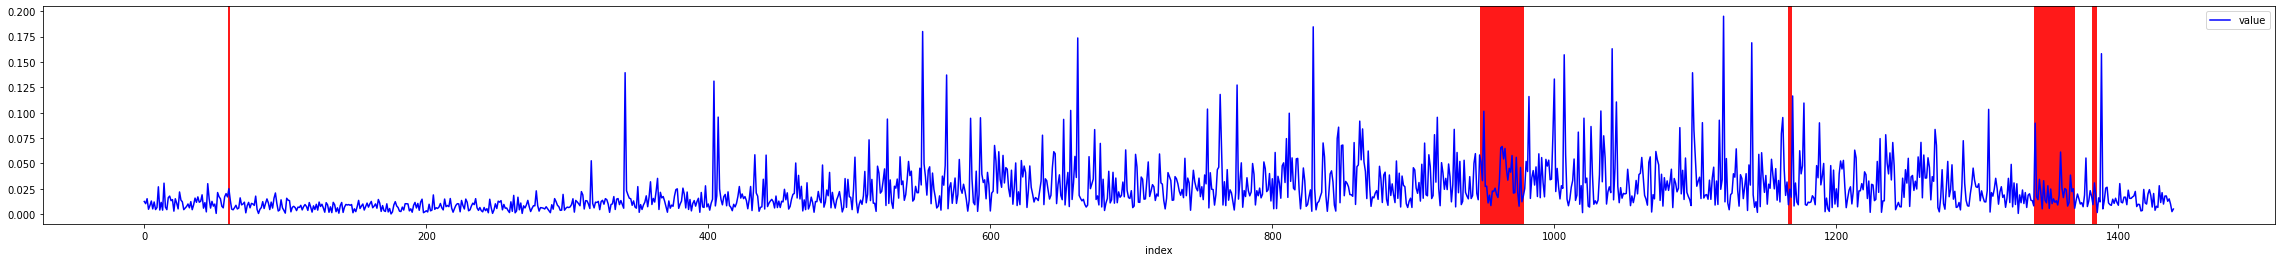

In [145]:
i=19
data = validation_final[i][0]
ground_truth = validation_final[i][1]
prediction = net(data.float().reshape(1, WINDOW_SIZE, 1))
prediction[prediction >= threshold] = 1
prediction[prediction < threshold] = 0
plots(data, prediction.detach().numpy().reshape(-1))